In [1]:
from src.utils import Averager
import os
from sklearn.preprocessing import LabelEncoder
from src.dataset import FrameDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from src.utils import collate_fn
import torch

In [5]:
le = LabelEncoder()
le.fit(['abackground', 'human', 'bicycle', 'motorcycle', 'vehicle', 'human-ride-bicycle', 'human-ride-motorcycle', 'human-walk-motorcycle']);
print(le.transform(le.classes_))

[0 1 2 3 4 5 6 7]


In [3]:
dataset = FrameDataset(r'data\mini_test_folder', label_encoder=le)
dataloader = DataLoader(dataset, shuffle=True, batch_size=4, collate_fn=collate_fn)

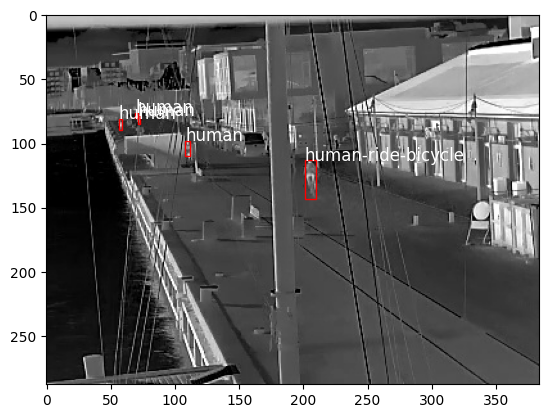

In [4]:
train_features, train_labels = next(iter(dataloader))#can check either train or val data
img = train_features[0].numpy().transpose(1, 2 , 0)
plt.imshow(img)

boxes = train_labels[0]['boxes'].numpy()
labels = train_labels[0]['labels'].numpy()
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    label = le.inverse_transform([label])[0]
    plt.text(x1, y1, label, fontsize = 12, c='white')
    plt.gca().add_patch(Rectangle((x1,y1),(x2-x1),(y2-y1),
                    edgecolor='red',
                    facecolor='none',
                    lw=1))
    
plt.show()

In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda')
model = fasterrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=9) 

model.train()
model.to(device);

In [7]:
from tqdm import tqdm
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00001)
train_loss_hist = Averager()
val_loss_hist = Averager()
best_valid_loss=float('inf')
max_epochs=10

for epoch in range(max_epochs):
    print(f"\nEPOCH {epoch+1} of {max_epochs}")
    train_loss_hist.reset()
    #Training step
    prog_bar = tqdm(dataloader, total=len(dataloader), leave=True)
    for frames, targets in prog_bar:
        
        frames = [frame.to(device) for frame in frames]
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(frames, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   

    # # #Validation step
    # val_loss_hist.reset()  
    
    # prog_bar = tqdm(val_dataloader, total=len(val_dataloader), leave=True)
    # for frames, targets in prog_bar:

    #     frames = [frame.to(device) for frame in frames]
    #     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    #     with torch.no_grad():
    #         loss_dict = model(frames, targets) 
        
    #     losses = sum(loss for loss in loss_dict.values())
    #     loss_value = losses.item()

    #     val_loss_hist.send(loss_value)      
     
    # print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")

    # #Saving best model
    # if val_loss_hist.value < best_valid_loss:
    #     best_valid_loss = val_loss_hist.value
    #     print(f"\nBest validation loss: {best_valid_loss}")
    #     print(f"\nSaving best model for epoch: {epoch+1}\n")
torch.save(model, os.path.join('products', 'epoch' + str(epoch + 1) + '-best_model.pth'))
print('Training Complete')


EPOCH 1 of 10


100%|██████████| 426/426 [03:11<00:00,  2.23it/s]


Epoch #1 train loss: 0.485

EPOCH 2 of 10


100%|██████████| 426/426 [03:07<00:00,  2.27it/s]


Epoch #2 train loss: 0.467

EPOCH 3 of 10


100%|██████████| 426/426 [03:08<00:00,  2.26it/s]


Epoch #3 train loss: 0.448

EPOCH 4 of 10


100%|██████████| 426/426 [03:07<00:00,  2.27it/s]


Epoch #4 train loss: 0.428

EPOCH 5 of 10


100%|██████████| 426/426 [03:07<00:00,  2.27it/s]


Epoch #5 train loss: 0.413

EPOCH 6 of 10


100%|██████████| 426/426 [03:07<00:00,  2.27it/s]


Epoch #6 train loss: 0.401

EPOCH 7 of 10


100%|██████████| 426/426 [03:07<00:00,  2.27it/s]


Epoch #7 train loss: 0.388

EPOCH 8 of 10


100%|██████████| 426/426 [03:07<00:00,  2.28it/s]


Epoch #8 train loss: 0.377

EPOCH 9 of 10


100%|██████████| 426/426 [03:07<00:00,  2.27it/s]


Epoch #9 train loss: 0.366

EPOCH 10 of 10


100%|██████████| 426/426 [03:05<00:00,  2.29it/s]


Epoch #10 train loss: 0.357
Training Complete


In [3]:
device = torch.device('cuda')
model = torch.load('products/epoch10-best_model.pth')#Insert model path here
model.eval()
model.to(device);

In [10]:
import cv2

video_path = 'data/data_inter/clips/20200518/clip_27_1219.mp4'
frames_list = []
size = (384, 288)
model.to(device)
cap = cv2.VideoCapture(video_path)
output_path = 'outputs/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
counter = 0
while(True):
    ret, frame = cap.read()
    if (ret == True):
        # if counter%25 == 0:
        tens_frame = (frame/255).transpose((2, 0, 1))
        tens_frame = torch.tensor(tens_frame).type(torch.float).unsqueeze(0)
        tens_frame = tens_frame.to(device)
        with torch.no_grad():
            prediction = model(tens_frame)

        boxes = prediction[0]['boxes'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = le.inverse_transform(labels)

        for box, label, score in zip(boxes, labels, scores):
            if score > 0.7:
                x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])

                cv2.putText(frame,label,(x1,y1-4),cv2.FONT_HERSHEY_SIMPLEX,0.4,(0,255,0),1,cv2.LINE_AA)
                cv2.rectangle(frame,(x1, y1),(x2, y2),(255,0,0),1)
        
        # frames_list.append(frame)
        cv2.imshow('video', frame)
        # counter += 1
        if cv2.waitKey(4) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
            
        else:
            counter += 1
        
    else: 
        cv2.destroyAllWindows()
        break

# out = cv2.VideoWriter('project.avi',cv.VideoWriter_fourcc(*'DIVX'), 25, size)
 
# for i in range(len(frames_list)):
#     out.write(frames_list[i])
# out.release()